# LIBRARIES 

In [1]:
import math
import keras
from keras import backend as K
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# TRAINING AND TESTING DATA

# size of batch( considering entire dataset is a tedious task and hence we consider a batch which is group of images)

# preprocessing function is used for preprocessing of images which means mapping the pixels in the image between the values of 0 and 1

# image data generator is used to augment images when model is still in training phase which means adding transformations to images and genrating variety of images  and here we are importing the orginal set of images from directory.

In [2]:
batch_size = 16

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_gen.flow_from_directory(
    directory="../dataset/training_set",
    target_size=(224,224),# size of image
    batch_size=batch_size,
    class_mode='categorical',#used for multi class problems
    shuffle=True # shuffles images in dataset so that model dont get overtrained
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_gen.flow_from_directory(
    directory="../dataset/test_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


# MOBILENETV2 MODEL

# input shape- input image resolution
# include_top- specifies whether to include the fully-connected layer at the top of the network
# weights- path of the weights file that used, here imagenet which is pretrained

# dense
# 2-units-output shape-2 classes here
# activation - softmax - predict classes based on the highest probability among all the classes.
# kernel_regularizer- penality applied on layer kernel and these penalties are added into loss function- l2=0.001 - here penality means reducing the weights of insignificant parameters

In [3]:
#imports the mobilenet model and discards the last fully connected neuron layer.
mobilenetmodel = MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)#importing moblienet model
print(mobilenetmodel.summary())#print the summary about model which gives description on model parameters.

x = mobilenetmodel.output #storing output of mobilenet model to x
x = GlobalAveragePooling2D()(x) #globalAveragePooling2d() function is used for applying global average pooling operation on x
preds = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x) # adding final layer with softmax activation

model_final = Model(inputs = mobilenetmodel.input, outputs = preds) # final model with input of mobilenet model and output known as preds

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# COMPILATION

# optimizer - used to change attributes of model and improve accuracy

# SGD-stochastic gradient descent - instead of considering whole dataset as a batch sgd considers batch of size 1 per each iteration to achieve minima - lesser computation

# metrics- model compiled to determine accuracy

# binary_crossentropy - loss function used for binary class problems-calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual values(0,1).

# compile() - used to define loss function,optimizer,metrics etc. Compiling a model is required to finalise the model and make it completely ready to use. 

In [4]:
training_size = 6000 #training dataset size
validation_size = 3000 #testing dataset size
steps_per_epoch = math.ceil(training_size / batch_size)
print(steps_per_epoch)#no of steps means no of batches for one epoch
validation_steps = math.ceil(validation_size / batch_size)
print(validation_steps)
# compilation 1
optimizer1 = SGD(learning_rate=0.001)
model_final.compile(optimizer = optimizer1, loss='binary_crossentropy',metrics=['accuracy'])
print("total layer count", len(model_final.layers)) #model_final.layers is a array containing layers and total layer count is length of the array


375
188
total layer count 156


# MODEL SUMMARY

In [5]:
print(model_final.summary()) #model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# FIT THE MODEL

# Shuffles help to feed different data into the model during training, It helps with the accuracy of the model by getting different batches of input before each epoch.

# Callback is an object that can perfom actions at various stages of training and it can be passed to fit().

# Workers used for faster data processing - number of threads(multi processing) generating batches in parallel. Batches are computed in parallel on the CPU.

# HDF5(Hierarchical Data Format) is a general purpose library and file format for storing large,complex,hetrogenous, scientific data (ex:datasets) 

In [6]:
earlystop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
hist1 = model_final.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=2, #2 complete cycles through entire dataset
    validation_data = test_set,
    validation_steps=validation_steps,
    callbacks=[earlystop1],
    workers=10,
    shuffle=True
) #fit() is for training the model with the given inputs (and corresponding training labels).

model_final.save("watermark_mobilenetmodel.h5") #saving final model as hdf file

print("mobilenet_watermark_class_indices", training_set.class_indices) # currency class labels and their encoding
f = open("mobilenet_watermark_class_indices.txt", "w") #opening a text file
f.write(str(training_set.class_indices)) # writing this class labels into a text file
f.close() #closing a file

Epoch 1/2
375/375 [==============================] - 541s 1s/step - loss: 0.3956 - accuracy: 0.8655 - val_loss: 0.3116 - val_accuracy: 0.9050
Epoch 2/2
375/375 [==============================] - 533s 1s/step - loss: 0.1723 - accuracy: 0.9483 - val_loss: 0.1484 - val_accuracy: 0.9543
mobilenet_watermark_class_indices {'no_watermark': 0, 'yes_watermark': 1}


# PLOTTING

# history callback - records training metrics for each epoch and can use data stored in history object to create plots

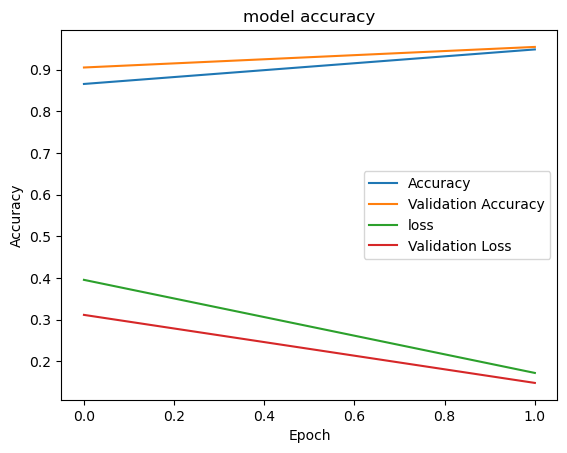

In [7]:
plt.plot(hist1.history["accuracy"])#accuracy
plt.plot(hist1.history['val_accuracy'])#validation accuracy
plt.plot(hist1.history['loss'])#loss
plt.plot(hist1.history['val_loss'])#validation loss
plt.title("model accuracy")#title of graph
plt.ylabel("Accuracy")#ylabel
plt.xlabel("Epoch")#xlabel
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])#legend
plt.savefig('mobilenet' + '_plot.png')#saving plot
plt.show() #displaying plot

# COMPLETE CODE

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']              

                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
          

 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_d

 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
          

                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
          

                                                                                                  
 expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             
 wiseConv2D)                    )                                                                 
                                                                                                  
 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']
 tchNormalization)              )                                                                 
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0
 ReLU)                          )                                ]']                              
                                                                                                  
 expanded_

 block_3_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     
                                                                                                  
 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      
                                                                                                  
 block_4_d

C:\Users\Charan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
          

 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_

 block_14_expand (Conv2D)       (None, 7, 7, 960)    153600      ['block_13_project_BN[0][0]']    
                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 7, 7, 960)   3840        ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_

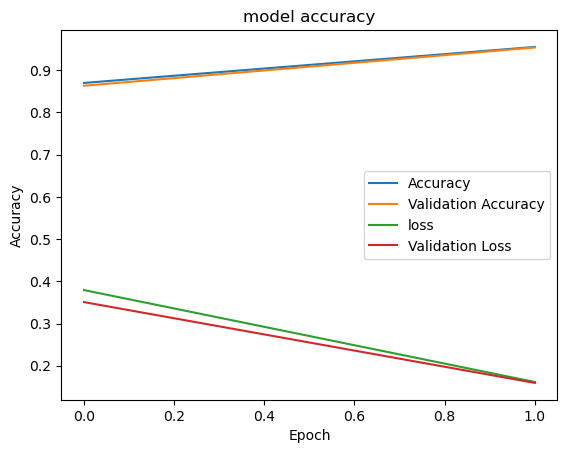

In [1]:
import math
import keras
from keras import backend as K
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

batch_size = 16

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_gen.flow_from_directory(
    directory="../dataset/training_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_gen.flow_from_directory(
    directory="../dataset/test_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

#imports the mobilenet model and discards the last fully connected neuron layer.
mobilenetmodel = MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)
print(mobilenetmodel.summary())

x = mobilenetmodel.output
x = GlobalAveragePooling2D()(x)
preds = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x) # final layer with softmax activation

model_final = Model(inputs = mobilenetmodel.input, outputs = preds)

training_size = 6000
validation_size = 3000
steps_per_epoch = math.ceil(training_size / batch_size)
validation_steps = math.ceil(validation_size / batch_size)

# compilation 1
optimizer1 = SGD(lr=0.001)
model_final.compile(optimizer = optimizer1, loss='binary_crossentropy',metrics=['accuracy'])
print("total layer count", len(model_final.layers))

print(model_final.summary())
earlystop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
hist1 = model_final.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=2,
    validation_data = test_set,
    validation_steps=validation_steps,
    callbacks=[earlystop1],
    workers=10,
    shuffle=True
)

model_final.save("watermark_mobilenetmodel.h5")

print("mobilenet_watermark_class_indices", training_set.class_indices)
f = open("mobilenet_watermark_class_indices.txt", "w")
f.write(str(training_set.class_indices))
f.close()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('mobilenet' + '_plot.png')
plt.show()